# UNet сегментация

## Kaggle датасет

In [1]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision import models

from skimage import data

from PIL import Image

from tqdm import trange, tqdm

from sklearn.model_selection import train_test_split

In [2]:
import os

dataset_path = "/kaggle/input/minerals-own-data/minerals_own_data.v2i.coco-segmentation"
train_images_path = os.path.join(dataset_path, "images/train")
train_masks_path = os.path.join(dataset_path, "annotations/train")
test_images_path = os.path.join(dataset_path, "images/test")
test_masks_path = os.path.join(dataset_path, "annotations/test")

# Проверяем файлы
print("Train Images:", len(os.listdir(train_images_path)))
print("Train Masks:", len(os.listdir(train_masks_path)))
print("Test Images:", len(os.listdir(test_images_path)))
print("Test Masks:", len(os.listdir(test_masks_path)))

# Выведем первые 5 файлов
print("\nПримеры файлов (Train Images):", os.listdir(train_images_path)[:5])
print("Примеры файлов (Train Masks):", os.listdir(train_masks_path)[:5])

Train Images: 229
Train Masks: 229
Test Images: 30
Test Masks: 30

Примеры файлов (Train Images): ['74_jpg.rf.d45406fa142a37243d2547ca0a8a705d.jpg', '69_jpg.rf.a01600479e087df26de8f13ed340bfbe.jpg', '76_jpg.rf.6bb905aa857377f36da5e4c129dc2439.jpg', '55_jpg.rf.8e012e9d83d6f3af99005b4e5d1b0310.jpg', '86_jpg.rf.d97c82797b5e2aacaec77436fef646ee.jpg']
Примеры файлов (Train Masks): ['30_jpg.rf.69ffd03a987dc06b10f175d147e0ec20.png', '67_jpg.rf.df2aa379150420e62a24c615ae68d072.png', '49_jpg.rf.0c9f73dd3fe37e513607a7d0a73055aa.png', '60_jpg.rf.7a314000fd76c380b07a5f5b44f9211c.png', '41_jpg.rf.e8104afc6b9606f8a39eb7853b6bb743.png']


✅ Изображение: (256, 256, 3), Маска: (256, 256), dtype: uint8


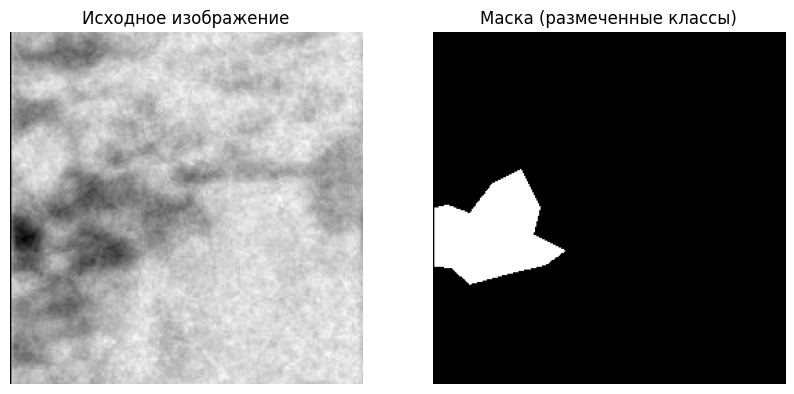

In [3]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

# Функция для загрузки и отображения изображения и маски
def visualize_sample(image_path, mask_path):
    # Проверяем существование файлов
    if not os.path.exists(image_path):
        print(f"❌ Изображение не найдено: {image_path}")
        return
    if not os.path.exists(mask_path):
        print(f"❌ Маска не найдена: {mask_path}")
        return
    
    # Загружаем изображение
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR → RGB

    # Загружаем маску (через PIL, чтобы точно было корректно)
    mask = Image.open(mask_path).convert("L")  # Преобразуем в оттенки серого
    mask = np.array(mask)

    # Выводим информацию о загруженных данных
    print(f"✅ Изображение: {image.shape}, Маска: {mask.shape}, dtype: {mask.dtype}")

    # Отображаем
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title("Исходное изображение")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Маска (размеченные классы)")
    ax[1].axis("off")

    plt.show()

# Получаем список файлов
image_files = sorted(os.listdir(train_images_path))
mask_files = sorted(os.listdir(train_masks_path))

# Выбираем случайное изображение
sample_image = image_files[0]  # Берем первое изображение

# Находим соответствующую маску, заменяя расширение
sample_mask = os.path.splitext(sample_image)[0] + ".png"

# Полные пути
image_path = os.path.join(train_images_path, sample_image)
mask_path = os.path.join(train_masks_path, sample_mask)

# Визуализация
visualize_sample(image_path, mask_path)


In [4]:
mask_files = sorted(os.listdir(train_masks_path))

all_classes = set()

for mask_file in mask_files:
    mask_path = os.path.join(train_masks_path, mask_file)
    mask = Image.open(mask_path)
    mask_array = np.array(mask)
    
    unique_classes = np.unique(mask_array)
    all_classes.update(unique_classes)

print(f"Общее количество уникальных классов: {len(all_classes)}")
print(f"Уникальные классы: {sorted(all_classes)}")

Общее количество уникальных классов: 2
Уникальные классы: [0, 1]


## PyTorch датасет и даталоадер

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import cv2
import numpy as np
from PIL import Image

# Dataset для сегментации с ресайзом
class SegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, img_size=512):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_filenames = sorted(os.listdir(images_dir))  # Сортируем файлы, чтобы соответствовали
        self.transform = transform
        self.img_size = img_size  # Размер изображения

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Получаем имя файла и путь
        image_filename = self.image_filenames[idx]
        mask_filename = os.path.splitext(image_filename)[0] + ".png"  # Меняем .jpg → .png
        image_path = os.path.join(self.images_dir, image_filename)
        mask_path = os.path.join(self.masks_dir, mask_filename)

        # Загружаем изображение (BGR → RGB, нормализация)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (self.img_size, self.img_size))  # Ресайз до 512x512
        image = image.astype(np.float32) / 255.0  # Нормализация [0,1]

        # Конвертируем изображение в три канала (копируем одно и то же изображение в 3 канала)
        image = np.stack([image, image, image], axis=-1)  # [H, W, 3]

        # Загружаем маску (градации серого)
        mask = Image.open(mask_path).convert("L")  # Преобразуем в оттенки серого
        mask = mask.resize((self.img_size, self.img_size), Image.NEAREST)  # Ресайз маски (NEAREST для классов)
        mask = np.array(mask, dtype=np.int64)  # Оставляем как int64 (классы)

        # Применяем аугментации (если заданы)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        # Преобразуем в тензоры
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # [H, W, C] → [C, H, W]
        mask = torch.tensor(mask, dtype=torch.long)  # [H, W] (не OHE!)

        return image, mask

# Проверим на train-данных
train_dataset = SegDataset(train_images_path, train_masks_path, img_size=512)

# Проверим размерность данных
sample_img, sample_mask = train_dataset[0]
print(f"Форма изображения: {sample_img.shape}")  # [3, 512, 512]
print(f"Форма маски: {sample_mask.shape}")        # [512, 512]
print(f"Классы в маске: {torch.unique(sample_mask)}")  # Проверяем, что классы от 0 до 114


Форма изображения: torch.Size([3, 512, 512])
Форма маски: torch.Size([512, 512])
Классы в маске: tensor([0, 1])


## Classic U-net
U-Net: Convolutional Networks for Biomedical Image Segmentation


<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="drawing" width="800"/>


Перейдем к самой сети U-net - в ней не просто принимаем на вход изображение, сжимаем его, а потом разжимаем, но при это еще делим глобальные skip connection'ы (серые стрелки). Важно, чтобы все работало, чтобы выход слоя (начало стрелка) должен совпадать с входом слоя (остриё стрелки), поэтому надо соблюдать такую совместимость.

Посмотрим, какой размер идет на вход и какой получается на выходе. В нашем примере на вход 3 (канала) и размерность изображения (384, 512), а на выходе хотим маску, у которой будет 1 канал, а при этом этот 1 канал будет отвечать за 1 класс (в нашем случае датасет состоит из 1 класса - человек). Если было бы несколько классов, то на выходе было бы несколько каналов и выдавались, например, двухканальное бинарное изображение, где первый канал отвечал за человека, а второй за кота.

Implementation

https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [6]:
# Параметры
BATCH_SIZE = 8
NUM_WORKERS = 2

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

# Проверим батч
batch_images, batch_masks = next(iter(train_loader))
print(f"Размер batch изображений: {batch_images.shape}")  # [B, 3, 512, 512]
print(f"Размер batch масок: {batch_masks.shape}")        # [B, 512, 512]

Размер batch изображений: torch.Size([8, 3, 512, 512])
Размер batch масок: torch.Size([8, 512, 512])


In [7]:
import torchvision.models.segmentation as segmentation
deeplab = segmentation.deeplabv3_resnet50(pretrained=True)
deeplab.backbone

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 218MB/s] 


IntermediateLayerGetter(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [8]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

# Загружаем backbone из DeepLabV3+
backbone = deeplabv3_resnet50(pretrained=True).backbone

# Тестовый входной тензор (имитируем изображение 512x512 с 3 каналами)
x = torch.randn(1, 3, 512, 512)

# Проход по слоям и вывод их размеров
s1 = backbone.conv1(x)  # После первого сверточного слоя
s1 = backbone.bn1(s1)  # После BatchNorm
s1 = backbone.relu(s1)  # После ReLU
s1 = backbone.maxpool(s1)  # После MaxPool
print(f"s1 (после maxpool): {s1.shape}")  # Ожидаем (1, 64, 128, 128)

s2 = backbone.layer1(s1)
print(f"s2: {s2.shape}")  # Ожидаем (1, 256, 128, 128)

s3 = backbone.layer2(s2)
print(f"s3: {s3.shape}")  # Ожидаем (1, 512, 64, 64)

s4 = backbone.layer3(s3)
print(f"s4: {s4.shape}")  # Ожидаем (1, 1024, 32, 32)

bottleneck = backbone.layer4(s4)
print(f"bottleneck: {bottleneck.shape}")  # Ожидаем (1, 2048, 16, 16)


s1 (после maxpool): torch.Size([1, 64, 128, 128])
s2: torch.Size([1, 256, 128, 128])
s3: torch.Size([1, 512, 64, 64])
s4: torch.Size([1, 1024, 64, 64])
bottleneck: torch.Size([1, 2048, 64, 64])


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.segmentation import deeplabv3_resnet50

class UNetDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        # Адаптер для приведения skip к нужному числу каналов
        self.skip_conv = nn.Conv2d(skip_channels, out_channels, kernel_size=1)
        
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.upconv(x)
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)  
        
        skip = self.skip_conv(skip)  # Преобразуем skip-карту
        x = torch.cat([x, skip], dim=1)  
        x = self.conv(x)
        return x

class UNetWithDeepLabEncoder(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.encoder = deeplabv3_resnet50(pretrained=True).backbone
        
        # Извлекаем слои энкодера (последовательные уровни ResNet)
        self.enc1 = nn.Sequential(self.encoder.conv1, self.encoder.bn1, self.encoder.relu, self.encoder.maxpool)
        self.enc2 = self.encoder.layer1  # 256
        self.enc3 = self.encoder.layer2  # 512
        self.enc4 = self.encoder.layer3  # 1024
        self.enc5 = self.encoder.layer4  # 2048 (bottleneck)
        
        # Декодер с использованием skip connections
        self.dec4 = UNetDecoderBlock(2048, 512, 1024)
        self.dec3 = UNetDecoderBlock(512, 256, 512)
        self.dec2 = UNetDecoderBlock(256, 128, 256)
        self.dec1 = UNetDecoderBlock(128, 64, 64)   # 128 -> 64
        
        # Финальный слой для сегментации
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Энкодер (из DeepLabV3+)
        s1 = self.enc1(x)  # 64, 128x128
        s2 = self.enc2(s1)  # 256, 128x128
        s3 = self.enc3(s2)  # 512, 64x64
        s4 = self.enc4(s3)  # 1024, 64x64
        bottleneck = self.enc5(s4)  # 2048, 64x64
        
        # Декодер с skip connections
        d4 = self.dec4(bottleneck, s4)  # 512, 64x64
        d3 = self.dec3(d4, s3)  # 256, 64x64
        d2 = self.dec2(d3, s2)  # 128, 128x128
        d1 = self.dec1(d2, s1)  # 64, 128x128
        
        # Выходное изображение
        out = self.final_conv(d1)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)  # Восстанавливаем до 512x512
        return out

# Тест модели
if __name__ == "__main__":
    model = UNetWithDeepLabEncoder(num_classes=1)
    x = torch.randn(1, 3, 512, 512)
    y = model(x)
    print(f"Output shape: {y.shape}")  # Должно быть (1, 1, 512, 512)


Output shape: torch.Size([1, 1, 512, 512])


In [10]:
# Проверим модель
unet = UNetWithDeepLabEncoder(num_classes=1)
x = torch.randn(1, 3, 1024, 1024)
out = unet(x)
print(out.shape)

torch.Size([1, 1, 1024, 1024])


In [11]:
device="cuda"
model.load_state_dict(torch.load("/kaggle/input/u-net-mineralscreative15k/u-net-mineralscreative15k.pth"))
model.to(device)

<ipython-input-11-ec490384f250>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/u-net-mineralscreative15k/u-net-mineralscrea

UNetWithDeepLabEncoder(
  (encoder): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (dow

In [12]:
# Замораживаем backbone (энкодер)
for name, param in model.encoder.named_parameters():
    param.requires_grad = False
    print(f"Заморожено: {name}")

# Размораживаем декодер (по частям)
for layer in [model.dec2, model.dec1, model.final_conv]:
    for name, param in layer.named_parameters():
        param.requires_grad = True
        print(f"Разморожено: {name}")

# Проверка финального состояния
print("\nПроверка:")
print("Backbone layers (должно быть True):")
for name, param in model.encoder.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

print("\nDecoder layers (должно быть True):")
for layer in [model.dec4, model.dec3, model.dec2, model.dec1, model.final_conv]:
    for name, param in layer.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")





Заморожено: conv1.weight
Заморожено: bn1.weight
Заморожено: bn1.bias
Заморожено: layer1.0.conv1.weight
Заморожено: layer1.0.bn1.weight
Заморожено: layer1.0.bn1.bias
Заморожено: layer1.0.conv2.weight
Заморожено: layer1.0.bn2.weight
Заморожено: layer1.0.bn2.bias
Заморожено: layer1.0.conv3.weight
Заморожено: layer1.0.bn3.weight
Заморожено: layer1.0.bn3.bias
Заморожено: layer1.0.downsample.0.weight
Заморожено: layer1.0.downsample.1.weight
Заморожено: layer1.0.downsample.1.bias
Заморожено: layer1.1.conv1.weight
Заморожено: layer1.1.bn1.weight
Заморожено: layer1.1.bn1.bias
Заморожено: layer1.1.conv2.weight
Заморожено: layer1.1.bn2.weight
Заморожено: layer1.1.bn2.bias
Заморожено: layer1.1.conv3.weight
Заморожено: layer1.1.bn3.weight
Заморожено: layer1.1.bn3.bias
Заморожено: layer1.2.conv1.weight
Заморожено: layer1.2.bn1.weight
Заморожено: layer1.2.bn1.bias
Заморожено: layer1.2.conv2.weight
Заморожено: layer1.2.bn2.weight
Заморожено: layer1.2.bn2.bias
Заморожено: layer1.2.conv3.weight
Замороже

### Обучение

[Epoch 1/10, Step 1/28] Loss: 7.6404, IoU: 0.0000, Accuracy: 0.8449
[Epoch 1/10, Step 11/28] Loss: 0.5449, IoU: 0.0107, Accuracy: 0.8434
[Epoch 1/10, Step 21/28] Loss: 0.5334, IoU: 0.0146, Accuracy: 0.8161
Epoch 1: Train Loss=1.2026, Train IoU=0.0126, Train Accuracy=0.8308
[Epoch 2/10, Step 1/28] Loss: 0.4101, IoU: 0.0380, Accuracy: 0.8541
[Epoch 2/10, Step 11/28] Loss: 0.3498, IoU: 0.5019, Accuracy: 0.8713
[Epoch 2/10, Step 21/28] Loss: 0.1974, IoU: 0.6109, Accuracy: 0.9349
Epoch 2: Train Loss=0.2660, Train IoU=0.4750, Train Accuracy=0.9178
[Epoch 3/10, Step 1/28] Loss: 0.2583, IoU: 0.4902, Accuracy: 0.9129
[Epoch 3/10, Step 11/28] Loss: 0.1570, IoU: 0.5793, Accuracy: 0.9413
[Epoch 3/10, Step 21/28] Loss: 0.1707, IoU: 0.7178, Accuracy: 0.9346
Epoch 3: Train Loss=0.1564, Train IoU=0.6414, Train Accuracy=0.9415
[Epoch 4/10, Step 1/28] Loss: 0.1170, IoU: 0.7126, Accuracy: 0.9551
[Epoch 4/10, Step 11/28] Loss: 0.1119, IoU: 0.6792, Accuracy: 0.9550
[Epoch 4/10, Step 21/28] Loss: 0.1679, Io

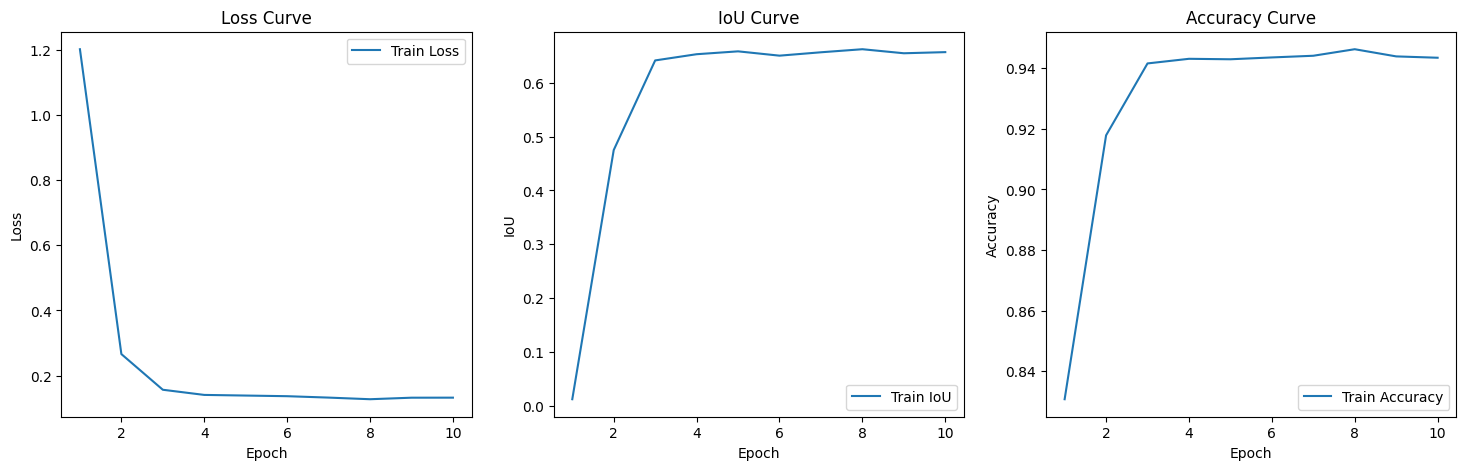

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Функция для вычисления IoU
def calculate_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).float()  # Бинаризуем предсказания
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = intersection / union if union > 0 else torch.tensor(1.0)  # Чтобы избежать деления на 0
    return iou.item()

# Функция для вычисления Accuracy
def calculate_accuracy(pred, target):
    pred = (pred > 0.5).float()  # Бинаризуем предсказания
    correct = (pred == target).sum()
    total = target.numel()  # Общее количество пикселей
    accuracy = correct / total
    return accuracy.item()

# Функция обучения
def train_model(model, train_loader, num_epochs=10, lr=0.001, device="cuda"):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()  # Используем BCE с логитами
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_ious, train_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, epoch_iou, epoch_accuracy = 0, 0, 0

        for i, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device).unsqueeze(1).float()  # Добавляем канал и приводим к float
        
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)  # Теперь размеры совпадают
            loss.backward()
            optimizer.step()

            iou = calculate_iou(outputs.sigmoid(), masks)
            accuracy = calculate_accuracy(outputs.sigmoid(), masks)  # Вычисляем accuracy

            epoch_loss += loss.item()
            epoch_iou += iou
            epoch_accuracy += accuracy

            if i % 10 == 0:  # Вывод каждые 10 итераций
                print(f"[Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(train_loader)}] Loss: {loss.item():.4f}, IoU: {iou:.4f}, Accuracy: {accuracy:.4f}")

        # Средние значения за эпоху
        train_losses.append(epoch_loss / len(train_loader))
        train_ious.append(epoch_iou / len(train_loader))
        train_accuracies.append(epoch_accuracy / len(train_loader))

        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train IoU={train_ious[-1]:.4f}, Train Accuracy={train_accuracies[-1]:.4f}")

    # Графики IoU, Loss и Accuracy
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(range(1, num_epochs+1), train_ious, label="Train IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.title("IoU Curve")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.show()

    torch.save(model.state_dict(), "u-net-minerals.pth")

# Запуск обучения
num_epochs = 10
learning_rate = 1e-4

train_model(model, train_loader, num_epochs=num_epochs, lr=learning_rate, device="cuda")


In [14]:
BATCH_SIZE = 8
NUM_WORKERS = 2
test_dataset = SegDataset(test_images_path, test_masks_path, img_size=512)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [15]:
import numpy as np
import torch

def calculate_iou(preds, masks, num_classes):
    """
    Функция для расчета IoU для всех классов.
    """
    iou_per_class = []
    
    # Если preds имеют дополнительную размерность (например, канал), то убираем её
    if preds.dim() > 2:
        preds = preds.squeeze(1)  # Убираем размерность канала, если она есть
    
    # Переводим в numpy
    preds = preds.cpu().numpy()
    masks = masks.cpu().numpy()

    for i in range(num_classes):  # Итерируем по всем классам
        intersection = np.logical_and(preds == i, masks == i).sum()
        union = (preds == i).sum() + (masks == i).sum() - intersection

        # Рассчитываем IoU для текущего класса
        iou = intersection / union if union > 0 else 1.0  # Если union = 0, IoU = 1 (по умолчанию)
        iou_per_class.append(iou)

    return np.mean(iou_per_class)  # Возвращаем среднее значение IoU по всем классам

# Прогон на тестовых данных
test_ious = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        # Логиты -> Вероятности -> Бинаризация
        logits = model(images)
        probs = torch.sigmoid(logits)  # Перевод логитов в вероятности
        preds = (probs > 0.5).long()  # Бинаризация

        # IoU для всех классов
        iou_batch = calculate_iou(preds, masks, num_classes=2)  # Например, 2 класса
        test_ious.append(iou_batch)

# Усредняем IoU по всем батчам
mean_iou = np.mean(test_ious)

print(f"Средний IoU на тестовой выборке: {mean_iou:.4f}")


Средний IoU на тестовой выборке: 0.7841


In [16]:
import numpy as np
import torch

def dice_score(preds, masks, num_classes):
    """
    Функция для расчета Dice Score для всех классов.
    """
    # Убираем лишний канал в предсказаниях
    preds = preds.squeeze(1)  # Убираем размерность канала
    preds = preds.cpu().numpy()
    masks = masks.cpu().numpy()

    dice_per_class = np.zeros(num_classes)

    for i in range(0, num_classes):
        intersection = np.logical_and(preds == i, masks == i).sum()
        union = (preds == i).sum() + (masks == i).sum()

        if union > 0:
            dice_per_class[i] = (2 * intersection) / union
    
    mean_dice = np.mean(dice_per_class[dice_per_class > 0]) if np.any(dice_per_class > 0) else 0.0
    return dice_per_class, mean_dice


# Прогон на тестовых данных
test_dices = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        # Логиты -> Вероятности -> Бинаризация
        logits = model(images)
        probs = torch.sigmoid(logits)  # Перевод логитов в вероятности
        preds = (probs > 0.5).long()  # Бинаризация

        # Dice Score
        _, mean_dice = dice_score(preds, masks, num_classes=2)
        test_dices.append(mean_dice)

# Усредняем Dice Score по всем батчам
mean_dice_score = np.mean(test_dices)

print(f"Средний Dice Score на тестовой выборке: {mean_dice_score:.4f}")

Средний Dice Score на тестовой выборке: 0.8680


In [17]:
from sklearn.metrics import precision_recall_curve, auc

def calculate_map(probs, masks):
    """
    Расчет AP для двух классов (фон + объект), если выход модели имеет 1 канал.
    
    probs: вероятности класса 1, shape [B, 1, H, W]
    masks: ground truth, shape [B, H, W], значения — 0 (фон), 1 (объект)
    """
    probs = probs.cpu().numpy()[:, 0, :, :]  # [B, H, W]
    masks = masks.cpu().numpy()

    ap_per_class = []

    for class_id in [0, 1]:
        y_true = (masks == class_id).astype(np.uint8).flatten()
        y_scores = (1 - probs if class_id == 0 else probs).flatten()

        if np.sum(y_true) == 0:
            ap_per_class.append(np.nan)
            continue

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        ap = auc(recall, precision)
        ap_per_class.append(ap)

    valid_aps = [ap for ap in ap_per_class if not np.isnan(ap)]
    mean_ap = np.mean(valid_aps) if valid_aps else 0.0

    return ap_per_class, mean_ap

test_map_scores = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        logits = model(images)
        probs = torch.sigmoid(logits)  # [B, 1, H, W]

        _, mean_ap = calculate_map(probs, masks)
        test_map_scores.append(mean_ap)

mean_map = np.mean(test_map_scores)
print(f"Средний mAP на тестовой выборке: {mean_map:.4f}")

Средний mAP на тестовой выборке: 0.9395


In [18]:
import torch

# Определяем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Переводим модель в режим оценки
model.to(device)
model.eval()

# Список для хранения предсказаний
predictions = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)

        # Получаем выход модели
        outputs = model(images)

        # Применяем сигмоиду и бинаризуем маску (1 при prob > 0.5, иначе 0)
        preds = (outputs.sigmoid() > 0.5).float()

        # Переводим тензоры на CPU и добавляем в список
        predictions.extend(preds.cpu().numpy())

print(f"Получены предсказания для {len(predictions)} изображений.")



Получены предсказания для 30 изображений.


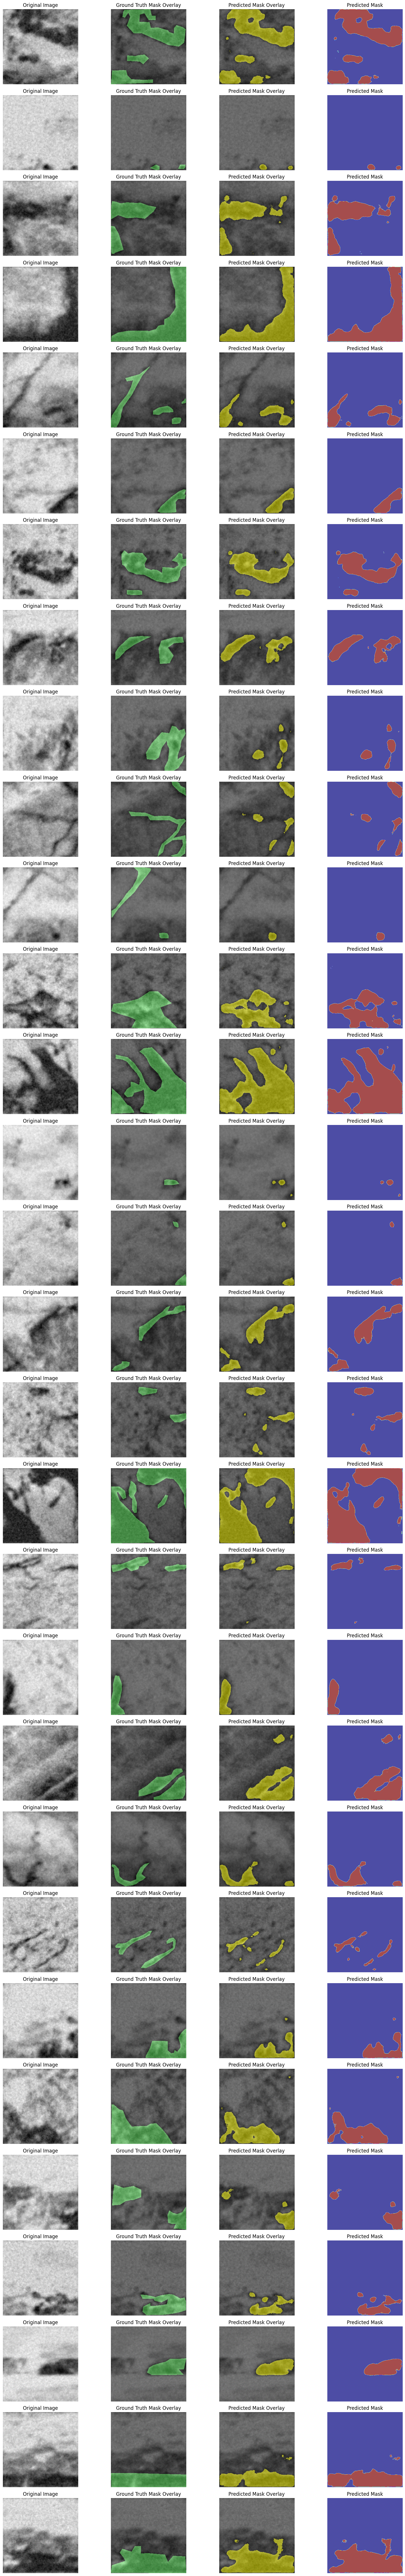

In [19]:
import random
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

def apply_mask(image, mask, color=(255, 0, 0), alpha=0.5):
    """Накладывает маску на изображение с прозрачностью."""
    colored_mask = np.zeros_like(image)
    for i in range(3):  
        colored_mask[:, :, i] = mask * color[i]
    
    return cv2.addWeighted(image, 1 - alpha, colored_mask, alpha, 0)

def visualize_predictions(test_loader, predictions, num_samples=10):
    """Визуализирует предсказания модели с наложением масок."""
    samples = random.sample(range(len(predictions)), num_samples)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 3))
    
    for i, idx in enumerate(samples):
        image, mask = test_loader.dataset[idx]
        image = image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
        mask = mask.numpy()
        pred_mask = predictions[idx].squeeze(0)  # Исправление! (1, H, W) -> (H, W)

        image_vis = (image * 255).astype(np.uint8)

        overlay_pred = apply_mask(image_vis, pred_mask, color=(255, 255, 0), alpha=0.5)
        overlay_gt = apply_mask(image_vis, mask, color=(100, 238, 100), alpha=0.5)

        axes[i, 0].imshow(image_vis)
        axes[i, 0].set_title("Original Image")
        
        axes[i, 1].imshow(overlay_gt)
        axes[i, 1].set_title("Ground Truth Mask Overlay")
        
        axes[i, 2].imshow(overlay_pred)
        axes[i, 2].set_title("Predicted Mask Overlay")
        
        axes[i, 3].imshow(pred_mask, cmap='jet', alpha=0.7)  # Теперь без ошибки!
        axes[i, 3].set_title("Predicted Mask")
        
        for ax in axes[i]:
            ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Визуализация предсказаний
visualize_predictions(test_loader, predictions, num_samples=30)


In [20]:
import random
from albumentations import Compose, HorizontalFlip, VerticalFlip, Rotate
from torch.utils.data import DataLoader
import numpy as np

def generate_random_tta():
    """Случайная комбинация горизонтального и вертикального флипа"""
    return Compose([
        HorizontalFlip(p=random.choice([0.0, 1.0])),
        VerticalFlip(p=random.choice([0.0, 1.0])),
        Rotate(limit=45, p=1.0)
    ])

# Создание датасетов с разными TTA-трансформами
tta_datasets = []
for i in range(5):
    tta_transform = generate_random_tta()
    dataset = SegDataset(
        test_images_path,
        test_masks_path,
        img_size=512,
        transform=tta_transform
    )
    tta_datasets.append(dataset)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [21]:
def evaluate_model_with_tta(model, datasets, device, num_classes=1):
    ious, dices, maps = [], [], []

    for dataset in datasets:
        loader = DataLoader(dataset, batch_size=4, shuffle=False)  # можно поменять batch_size
        iou_scores, dice_scores, map_scores = [], [], []

        with torch.no_grad():
            for images, masks in loader:
                images, masks = images.to(device), masks.to(device)
                logits = model(images)
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).long()
                masks = (masks > 0.5).long()
            
                iou = calculate_iou(preds, masks, num_classes=2)
                _, dice = dice_score(preds, masks, num_classes=2)
                _, mean_ap = calculate_map(preds, masks)
            
                iou_scores.append(iou)
                dice_scores.append(dice)
                map_scores.append(mean_ap)

        ious.append(np.nanmean(iou_scores))
        dices.append(np.mean(dice_scores))
        maps.append(np.mean(map_scores))

    return np.array(ious), np.array(dices), np.array(maps)

In [22]:
def compute_mean_std(metric_array):
    mean = np.mean(metric_array)
    std = np.std(metric_array, ddof=1)  # несмещённая оценка
    return mean, std

ious, dices, maps = evaluate_model_with_tta(model, tta_datasets, device)

mean_iou, std_iou = compute_mean_std(ious)
mean_dice, std_dice = compute_mean_std(dices)
mean_map, std_map = compute_mean_std(maps)

print("Aggregated metrics over TTA:")
print(f"IoU (defect): {mean_iou:.4f} ± {std_iou:.4f}")
print(f"Dice (defect): {mean_dice:.4f} ± {std_dice:.4f}")
print(f"mAP (defect): {mean_map:.4f} ± {std_map:.4f}")


Aggregated metrics over TTA:
IoU (defect): 0.7859 ± 0.0054
Dice (defect): 0.8662 ± 0.0041
mAP (defect): 0.8859 ± 0.0031
